In [1]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools, dft
import api as pyq 
import importlib
import os
import h5py
import pandas as pd
import pdb
import pyscf
import numpy as np
import pyqmc
import scipy
import copy
import gpu
import matplotlib.pyplot as plt
from pyscf.scf.hf import dump_scf_summary
from concurrent.futures import ProcessPoolExecutor
from pyscf.scf.chkfile import dump_scf
print(pyq.__file__)
print(pyscf.__file__)

/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/__init__.py


In [2]:
# Wavefunction generation
from scf_runs import run_lda_he, run_casci
scf_checkfile, opt_checkfile, mf_lda = run_lda_he()
ci_checkfile, mcc, opt_chkfile, vmc_chkfile = run_casci(scf_checkfile, nroots=1, ncas = 2)

/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/__init__.py
He atom neutral LDA spin=0
HF
converged SCF energy = -2.86151422722833  <S^2> = 2.4424907e-15  2S+1 = 1
LDA
converged SCF energy = -2.83456474290722  <S^2> = 3.1086245e-15  2S+1 = 1
CASCI nelecas up/down (1, 1)
CASCI E = -2.86531899726653  E(CI) = -2.86531899726653  S^2 = 0.0000000
Available output from CASCI: <KeysViewHDF5 ['ci', 'fci', 'mc_mo_energy', 'mf_mo_energy', 'mo_coeff', 'mo_occ', 'ncas', 'ncore', 'nelecas']>


In [77]:
import importlib, recipes, bosonrecipes, bosonslater, bosonaccumulators, bosonwftools, bosonslater_wf_based, mc, boson_stochastic_reconfiguration, slater, bosonenergy
modules = [recipes, bosonrecipes, bosonrecipes, bosonslater, bosonaccumulators, bosonwftools, mc, boson_stochastic_reconfiguration, slater, bosonenergy] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)


wfb, configs, accb = bosonrecipes.initialize_boson_qmc_objects(scf_checkfile, 
                                                               nconfig=1000, 
                                                               ci_checkfile=ci_checkfile, 
                                                               opt_wf = True, 
                                                               jastrow_kws = {"ion_cusp":False, 'na':0, 'nb':1, 'rcut':20}, 
                                                               det_emax = 1)
wfs, _, accs = recipes.initialize_qmc_objects(scf_checkfile, 
                                              nconfig=1000, 
                                              jastrow_kws = {"ion_cusp":False, 'na':0, 'nb':1, 'rcut':20}, 
                                             opt_wf = True)
accb = {"pgrad": accb}
accs = {"pgrad": accs}
# wf_old = bosonslater_wf_based.BosonWF(mf_lda.mol, mf_lda, mc)
# configs = bosonrecipes.initial_guess(mf_lda.mol, 1)

Determinants being filtered with percentage  1
Min eigenvalue -1.139
Max eigenvalue 0.697
Initial # of determinants 4
Filtered # of determinants 3
Used # of determinants 1
Will optimize:  dict_keys(['wf2acoeff', 'wf2bcoeff'])
Using spherical guess


In [78]:
accb

{'pgrad': <boson_stochastic_reconfiguration.BosonStochasticReconfiguration at 0x369e01110>}

In [79]:
accs

{'pgrad': <pyqmc.stochastic_reconfiguration.StochasticReconfiguration at 0x369defd50>}

In [80]:
tol = 1E-12

nconf, nelec, _ = configs.configs.shape

def is_equal(a, b, tag=None, printable = True):
    result = (np.abs(a-b) < tol).all()
    if not result:
        print(tag, result, 'diff', np.max(np.abs(a-b)), 'a', np.max(np.abs(a)), 'b', np.max(np.abs(b)))
    else:
        if printable:
            print(tag, result)
    return result
    
def limdrift(g, cutoff=1):
    """
    Limit a vector to have a maximum magnitude of cutoff while maintaining direction

    :parameter g: a [nconf,ndim] vector
    :parameter cutoff: the maximum magnitude
    :returns: The vector with the cutoff applied.
    """
    tot = np.linalg.norm(g, axis=1)
    mask = tot > cutoff
    g[mask, :] = cutoff * g[mask, :] / tot[mask, np.newaxis]
    return g


In [81]:
nsteps = 10
nelec = 2
tstep = 0.3
block_avgb = {}
block_avgs = {}
for _ in range(nsteps):
    acc = 0.0
    for e in range(nelec):
        import pdb
        sign_pb,  val_pb   = wfb.recompute(configs)
        sign_ps,  val_ps   = wfs.recompute(configs)
        is_equal(val_pb, val_ps, 'val')
        
        # pdb.set_trace()
        wf_kb = copy.deepcopy(wfb)
        wf_ks = copy.deepcopy(wfs)

        gb, _, _ = wfb.gradient_value(e, configs.electron(e))
        gs, _, _ = wfs.gradient_value(e, configs.electron(e))
        is_equal(gb, gs, 'g')
        
        gradb = limdrift(np.real(gb.T)) 
        grads = limdrift(np.real(gs.T)) 
        is_equal(gradb, grads, 'grad')
        
        gauss = np.random.normal(scale=np.sqrt(tstep), size=(nconf, 3))

        # is_equal(grad, grad_old, 'grad')
        newcoorde = configs.configs[:, e, :] + gauss + gradb * tstep
        newcoorde = configs.make_irreducible(e, newcoorde)

        # Compute reverse move
        g_kb, _, savedb = wf_kb.gradient_value(e, newcoorde)
        g_ks, _, saveds = wf_ks.gradient_value(e, newcoorde)
        is_equal(g_kb, g_ks, 'g_k')

        grad_kb = limdrift(np.real(g_kb.T)) 
        grad_ks = limdrift(np.real(g_ks.T)) 
        is_equal(grad_kb, grad_ks, 'grad_k')
        
        newcoord = copy.deepcopy(configs)
        newcoord.configs[:,e,:] = newcoorde.configs
        
        _, val_new_b = wf_kb.recompute(newcoord)
        _, val_new_s = wf_ks.recompute(newcoord)
        is_equal(val_new_b, val_new_s, 'val_new')

        forward = np.sum(gauss**2, axis=1)
        backward = np.sum((gauss + tstep * (gradb + grad_kb)) ** 2, axis=1)
        t_prob = np.exp(1 / (2 * tstep) * (forward - backward))
        ratio = np.exp(2*(val_new_b-val_pb))* t_prob
        
        accept = ratio > np.random.rand(nconf)
        wfb.updateinternals(e, newcoorde, configs, mask=accept, saved_values=savedb)
        wfs.updateinternals(e, newcoorde, configs, mask=accept, saved_values=saveds)
    for k, accumulator in accs.items():
            dat = accumulator.avg(configs, wfs)
            for m, res in dat.items():
                if k + m not in block_avgs:
                    block_avgs[k + m] = res / nsteps
                else:
                    block_avgs[k + m] += res / nsteps
    for k, accumulator in accb.items():
            dat = accumulator.avg(configs, wfb)
            for m, res in dat.items():
                if k + m not in block_avgb:
                    block_avgb[k + m] = res / nsteps
                else:
                    block_avgb[k + m] += res / nsteps        
        


val True
g True
grad True
g_k True
grad_k True
val_new True
val True
g True
grad True
g_k True
grad_k True
val_new True
val True
g True
grad True
g_k True
grad_k True
val_new True
val True
g True
grad True
g_k True
grad_k True
val_new True
val True
g True
grad True
g_k True
grad_k True
val_new True
val True
g True
grad True
g_k True
grad_k True
val_new True
val True
g True
grad True
g_k True
grad_k True
val_new True
val True
g True
grad True
g_k True
grad_k True
val_new True
val True
g True
grad True
g_k True
grad_k True
val_new True
val True
g True
grad True
g_k True
grad_k True
val_new True
val True
g True
grad True
g_k True
grad_k True
val_new True
val True
g True
grad True
g_k True
grad_k True
val_new True
val True
g True
grad True
g_k True
grad_k True
val_new True
val True
g True
grad True
g_k True
grad_k True
val_new True
val True
g True
grad True
g_k True
grad_k True
val_new True
val True
g True
grad True
g_k True
grad_k True
val_new True
val True
g True
grad True
g_k True
grad_

In [82]:
for k in block_avgs.keys():
    try:
        print(k, block_avgb[k], block_avgs[k])
    except:
        print(k, block_avgs[k])

pgradke 0.030573221587300685 0.0386508093658767
pgradee 0.5632872425882092 0.5632872425882092
pgradei -3.1284910364580383 -3.1284910364580383
pgradecp 0.0
pgradgrad2 4.415017850112349 4.415017850112349
pgradtotal -2.5289785765748 -2.526552984503952
pgraddpH [ 0.        +0.j -2.27506675+0.j  0.        +0.j] [ 0.       +0.j -2.2729671+0.j  0.       +0.j]
pgraddppsi [0.        +0.j 0.89866484+0.j 0.        +0.j] [0.        +0.j 0.89866484+0.j 0.        +0.j]
pgraddpidpj [[0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.81277497+0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j]] [[0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.81277497+0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j]]


In [34]:
import energy 
ek, grad2 = energy.kinetic(configs, wfs)

In [68]:
import importlib, recipes, bosonrecipes, bosonslater, bosonaccumulators, bosonwftools, bosonslater_wf_based, mc, boson_stochastic_reconfiguration, slater, bosonenergy
modules = [recipes, bosonrecipes, bosonrecipes, bosonslater, bosonaccumulators, bosonwftools, mc, boson_stochastic_reconfiguration, slater, bosonenergy] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
def loc_boson_kinetic(configs, wf):
    nconf, nelec, ndim = configs.configs.shape
    ke = np.zeros(nconf)
    has_jastrow = True
    try:
        wave_functions = wf.wf_factors
    except:
        has_jastrow = False
        wave_functions = [wf]
    boson_wf = wave_functions[0]
    jastrow_wf = wave_functions[1]
    lap_j = np.zeros(nconf)
    drift_b = np.zeros(nconf)
    grad2 = np.zeros(nconf)
    if has_jastrow:
        # If no jastrows (HF), then these terms are zero
        for e in range(nelec):
            _, val_je = jastrow_wf.value()            
            grad_je, lap_je = jastrow_wf.gradient_laplacian(e, configs.electron(e))
            # Convert to exp form of jastrow gradients from the jastrow log wavefunction
            # If \Psi_J = exp(J)
            # \frac{\nabla{e^{U(r)}}}{e^{U(r)}} = {\nabla^2}U(r) + {\nabla}U(r) \cdot {\nabla}U(r)}
            # If \Psi_J = exp(-J)
            # \frac{\nabla{e^{-U(r)}}}{e^{-U(r)}} = - [{\nabla^2}U(r) - {\nabla}U(r) \cdot {\nabla}U(r)}]
            # import pdb
            # pdb.set_trace()
            lap_j += -0.5 * lap_je
            # Last one            
            # lap_j += -0.5 * (lap_je.real + np.sum((grad_je.real)**2, axis=0))
            # lap_j += -0.5 * lap_je.real
            # lap_j += 0.5  * (lap_je.real + np.einsum("di,di->i",grad_j,np.conjugate(grad_j)))
            grad_b = boson_wf.gradient(e, configs.electron(e))
            drift_b += np.einsum("di,di->i", -grad_je, grad_b)
            grad = wf.gradient(e, configs.electron(e))
            grad2 += np.sum(np.abs(grad) ** 2, axis=0)
        # ke = lap_j + drift_b
    return lap_j, drift_b, grad2   

def loc_slater_kinetic(configs, wf):
    nconf, nelec, ndim = configs.configs.shape
    ke = np.zeros(nconf)
    wave_functions = wf.wf_factors
    slater_wf = wave_functions[0]
    jastrow_wf = wave_functions[1]
    lap_j = np.zeros(nconf)
    drift_b = np.zeros(nconf)
    grad2 = np.zeros(nconf)
    kes =0
    kej = 0 
    for e in range(nelec):
        grads, laps = slater_wf.gradient_laplacian(e, configs.electron(e))
        gradj, lapj = jastrow_wf.gradient_laplacian(e, configs.electron(e))
        kes += -0.5 * laps.real
        kej += -0.5 * lapj.real
    return kes, kej


kes, kej = loc_slater_kinetic(configs, wfs)    
ekab, ekbb, grad2 = loc_boson_kinetic(configs, wfb)

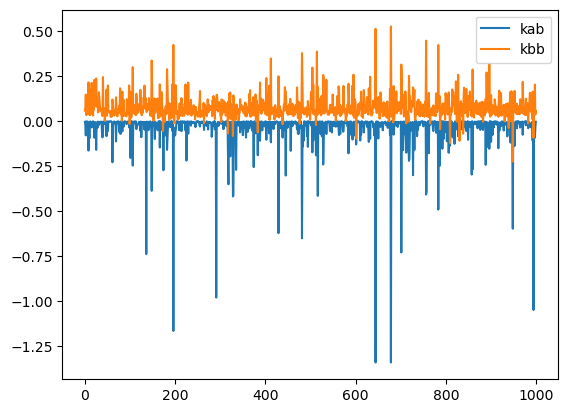

In [75]:
# plt.plot(kes, label='kes')
# plt.plot(kej, label='kej')
plt.plot(ekab, label='kab')
plt.plot(ekbb, label='kbb')
# plt.plot(ekab + ekbb, label='b_sum')
# plt.plot(ek, label='k')
plt.legend()

In [60]:
e = 0
epos = configs.electron(e)
grad_laps = [wfs.gradient_laplacian(e, epos) for wf in wfs.wf_factors]
grads, laps = list(zip(*grad_laps))
cross_term = np.zeros(laps[0].shape, dtype=wfs.dtype)

(1000,)

In [58]:
laps

(array([ 8.49625888e-01, -2.18762521e+00,  9.26374288e-01,  6.17375712e-01,
        -4.59388159e-01,  5.33364536e-01,  3.78732190e-01,  8.31583500e-01,
         8.08257900e-01,  3.63637141e-01, -6.10584634e-01,  3.26950579e-01,
         4.25958244e-01,  7.18759630e-01, -3.16339329e-01, -2.43829139e-01,
        -9.50723495e-01, -4.24138369e-01,  9.27568035e-01,  4.68942267e-01,
         5.63292589e-01, -5.97885918e+00,  4.48248050e-01, -2.20306961e+00,
        -6.31085921e-01,  2.50229739e-01,  5.24340912e-01,  5.18557271e-01,
         1.51271976e-01,  2.88412425e-01,  7.17761171e-01,  9.37261371e-01,
         6.68927558e-01, -1.10642577e-01,  4.72251385e-01,  8.11788585e-01,
        -2.50901508e-01, -2.59065786e-03, -4.52577753e-01,  2.64795488e-01,
        -7.97666610e-01,  4.63004417e-01,  5.64980102e-01,  1.76989008e-01,
         3.14900048e-01,  4.10715999e-01,  9.33861954e-01,  9.41003003e-01,
        -2.21342814e-01, -1.18841084e-01,  6.59905452e-01,  6.34855678e-01,
         3.3

In [47]:
wjb = wfb.wf_factors[1]
wjs = wfs.wf_factors[1]

In [48]:
b_grad, b_lap = wjb.gradient_laplacian(0, configs.electron(0))

In [49]:
s_grad, s_lap = wjs.gradient_laplacian(0, configs.electron(0))

In [ ]:
bosonenergy.

In [50]:
e = 0
epos = configs.electron(e)

In [36]:
s = int(e >= wfs.wf_factors[0]._nelec[0])
ao = wfs.wf_factors[0].orbitals.aos("GTOval_sph_deriv2", epos)
ao_val = ao[:, 0, :, :]
ao_lap = gpu.cp.sum(ao[:, [4, 7, 9], :, :], axis=1)
mos = gpu.cp.stack(
    [wfs.wf_factors[0].orbitals.mos(x, s)[..., wfs.wf_factors[0]._det_occup[s]] for x in [ao_val, ao_lap]]
)
ratios = wfs.wf_factors[0]._testrowderiv(e, mos)
lap = gpu.asnumpy(ratios[1] / ratios[0])